<a href="https://colab.research.google.com/github/Talendar/detecting_cats_and_dogs_images/blob/main/detecting_cats_and_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Transfer Learning to Classify Images of Cats and Dogs

In this project, we are going to classify images of cats and dogs with the help of transfer learning. This technique consists in harnessing a pre-trained model's knowledge, gained while solving one problem, to solve a different but related problem. We will also compare the results obtained with those obtained by a model trained from scratch (without the help of transfer learning).

The base model used is MobileNetV2, developed at Google. It was pre-trained on the ImageNet dataset, a research training dataset consisting of 1.4 million images and 1000 classes. Using the pre-acquired knowledge of this model will grealy help us classifying the images of cats and dogs in our dataset.

We can either freeze the pre-trained model's weights and use its lower layers as a fixed feature extractor, or we can fine-tune the pre-trained model by training it for a few epochs in our dataset. We will try both approaches and compare the results.

## **1) Dependencies**

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, EarlyStopping

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

#### Auxiliary functions:

In [33]:
def plot_history(hist):
    """ Plots the training history of a model. """
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(hist["accuracy"], label='Training Accuracy')
    plt.plot(hist["val_accuracy"], label='Validation Accuracy')
    plt.legend(loc='best')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(hist["loss"], label='Training Loss')
    plt.plot(hist["val_loss"], label='Validation Loss')
    plt.legend(loc='best')
    plt.ylabel('Cross Entropy Loss')
    plt.ylim([0,1.0])
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.show()


def print_performance(hist):
    """ Prints the models performance on the training and validation sets. """
    print('\nTraining loss: %.4f' % (hist["loss"][-1]))
    print('Training accuracy: %.2f%%' % (100*hist["accuracy"][-1]))

    print('\nValidation loss: %.4f' % (hist["val_loss"][-1]))
    print('Validation accuracy: %.2f%%' % (100*hist["val_accuracy"][-1]))


class ClearCallback(Callback):
    """ Handles the cleaning of the log during the training of a model. """

    def on_epoch_end(self, epoch, logs=None):
        """ Clears the log. Called when a training epoch ends. """
        clear_output(wait=True)

## **2) Loading, pre-processing and augmenting the data**

Let's start by downloading and extracting the *Cats and Dogs Dataset* from Google: 

In [ ]:
!wget -N https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
!unzip cats_and_dogs_filtered.zip

To load the images, we will use TensorFlow's ImageDataGenerator. By automatically loading, normalizing and performing data augmentation on the images, it makes our lives much easier. Let's create a new instance of that class and use it to load the training data:

In [3]:
IMG_SIZE = (160, 160)

train_image_gen = ImageDataGenerator(
    rescale=1/255,               # normalizes the pixel's values
    rotation_range=15,           # randomly rotates the images
    width_shift_range=0.12,      # radnomly shifts the images horizontally
    height_shift_range=0.12,     # randomly shifts the images vertically
    zoom_range=0.1,              # randomly zooms in/out the image
    fill_mode="nearest",         # mode to fill the "empty" new spaces
    horizontal_flip=True,        # flip the images horizontally
    vertical_flip=False,         # flips the images vertically
)

train_data_gen = train_image_gen.flow_from_directory(
    directory="./cats_and_dogs_filtered/train",
    target_size=IMG_SIZE,
    class_mode="binary",
    batch_size=32,
)

Found 2000 images belonging to 2 classes.


Now, we create a ImageDataGenerator to load the validation images. Note that we don't apply data augmentation here, only normalization.

In [4]:
val_image_gen = ImageDataGenerator(
    rescale=1/255,               # normalizes the pixel's values
)

val_data_gen = val_image_gen.flow_from_directory(
    directory="./cats_and_dogs_filtered/validation",
    target_size=IMG_SIZE,
    class_mode="binary",
    batch_size=32,
)

Found 1000 images belonging to 2 classes.


## **3) Exploring the data**

The ouput of our data generator at each step is a batch containing 32 (image, label) tuples.

In [7]:
print("Number of training batches: %d" % len(train_data_gen))
print("Number of validation batches: %d" % len(val_data_gen))
print("\nShape of a batch: {}".format(train_data_gen[0][0].shape))

Number of training batches: 63
Number of validation batches: 32

Shape of a batch: (32, 160, 160, 3)


Now, let's take a look at the images on the validation set (in which the data wasn't augmented):

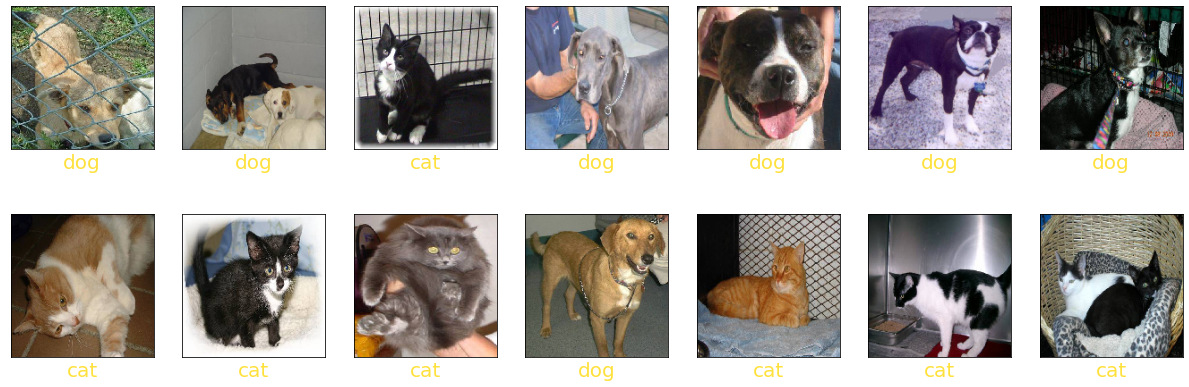

In [8]:
class_names = {v:k[:-1] for k,v in train_data_gen.class_indices.items()}  # maps each class id to its name
def plot_imgs(gen, num=14):
    """ Picks random images from the data generator and shows them. """
    imgs, labels = gen[np.random.randint(0, len(gen))]  # picks a random batch
    r = np.random.choice(np.arange(len(imgs)), num, replace=False)
    imgs, labels = imgs[r], labels[r]                   # selects random examples from the batch

    plt.figure(figsize=(21, 7))
    for i in range(num):
        plt.subplot(2, int(num/2), i+1)
        plt.xticks([])
        plt.yticks([])
        img, label = imgs[i], labels[i]
        plt.imshow(img)
        plt.xlabel(class_names[label], fontsize=20).set_color("#FFE13D")
    plt.show()


plot_imgs(val_data_gen)

Visualizing sample images of the traning set (in which the data was augmented!):

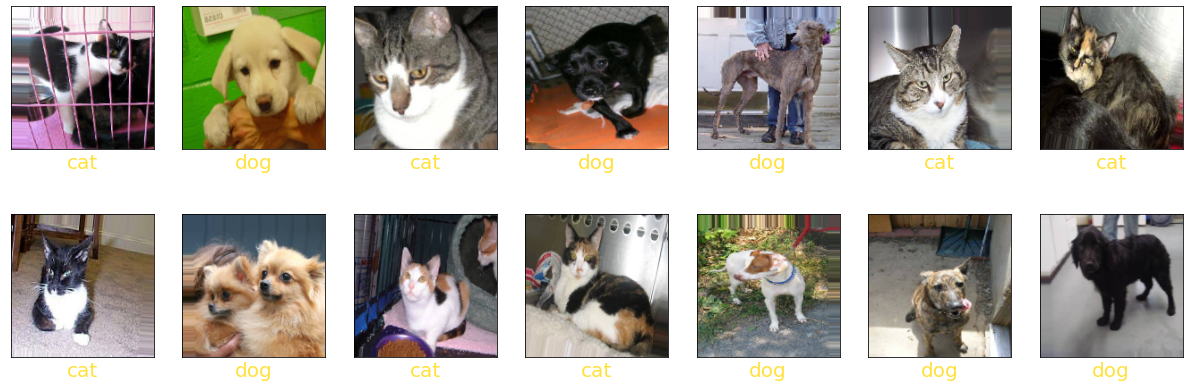

In [9]:
plot_imgs(train_data_gen)

## **4) Building and training a new model from scratch**

First, we build a new model from scratch and train it on our dataset:

63/63 [==============================] - 19s 298ms/step - loss: 0.3998 - accuracy: 0.8180 - val_loss: 0.4638 - val_accuracy: 0.7790

Training loss: 0.3998
Training accuracy: 81.80%

Validation loss: 0.4638
Validation accuracy: 77.90%


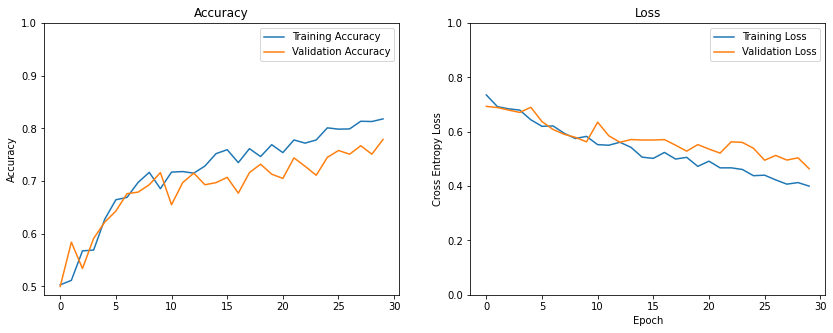

In [43]:
tf.keras.backend.clear_session()

# building a model based on the VGG models
model = tf.keras.Sequential([
    # block 1
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding="same", activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    # block 2
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same", activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    # block 3
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding="same", activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    # mlp
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dropout(0.3),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# training
hist1 = model.fit(train_data_gen, epochs=30,
              validation_data=val_data_gen, 
              callbacks=[ClearCallback(), 
                         EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

# visualizing performance
print_performance(hist1.history)
print()
plot_history(hist1.history)

## **5) Harnessing the experience of MobileNetV2**

Now that we've evaluated the performance of a newly built model, let's load MobileNetV2 to help us (transfer learning) with our task. We are interested only in the feature extraction layers, so we exclude the model's top layer (the classifier).

In [110]:
mobilenet_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,            # exclude the fully-connected classification layers
    weights='imagenet'
)

mn_features_sample = mobilenet_model(train_data_gen[0])
print("\nMobileNetV2 output shape: {}".format(mn_features_sample.shape))


MobileNetV2 output shape: (32, 5, 5, 1280)


### **5.1) Using MobileNetV2 to extract features**

First, we will use MobileNet merely as a fixed feature extractor. In order to do that, we must freeze its weights:

In [111]:
mobilenet_model.trainable = False
mobilenet_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

Global average pooling takes the average of each feature/activation map, resulting in a flat vector. By applying this technique on the output of MobileNet, we select "the most important" features detected. We then add a few extra top layers, which will be responsible to "make sense" of the features and classify the inputs. Check bellow:

In [112]:
tf.keras.backend.clear_session()

# building a new model using MobileNetV2 as feature extractor
model_mn = tf.keras.Sequential([
    mobilenet_model,                               # feature extractor
    tf.keras.layers.GlobalAveragePooling2D(),      # selects "the most important" features
    #tf.keras.layers.Dense(64, activation='relu'),
    #tf.keras.layers.Dropout(0.3),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_mn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


Now, let's train our new model, which uses MobileNet as a fixed feature extractor:

63/63 [==============================] - 19s 302ms/step - loss: 0.0590 - accuracy: 0.9770 - val_loss: 0.0936 - val_accuracy: 0.9610

Training loss: 0.0590
Training accuracy: 97.70%

Validation loss: 0.0936
Validation accuracy: 96.10%



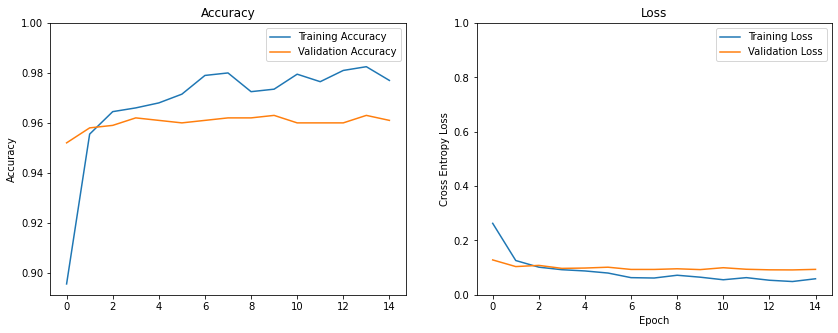

In [113]:
model_mn.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# training
hist2 = model_mn.fit(train_data_gen, epochs=15,
              validation_data=val_data_gen, 
              callbacks=[ClearCallback(), 
                         EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

# visualizing performance
print_performance(hist2.history)
print()
plot_history(hist2.history)

### **5.2) Fine-tuning MobileNetV2**

We've trained a few extra layers on top of MobileNetV2 without altering its weights (they were frozen!). Now, let's unfreeze those weights and fine-tune the base model on our dataset. We shouldn't unfreeze the weights of the first few layers though, since those layers learn very simple and generic features that generalize to almost all types of images.

Note that, in order to get good results, we must have trained extra layers on top of the base pre-trained model, like we've done above. Otherwise (if we add randomly initialzed top layers), the base model might forget what it has already learned.

In [156]:
mobilenet_model.trainable = True

stop_unfreezing = 100  # keeps the weights of the first n layers frozen
for layer in mobilenet_model.layers[:stop_unfreezing]:
    layer.trainable = False

print("We've unfrozen %d of %d MobileNetV2's layers!" % (len(mobilenet_model.layers) - stop_unfreezing, len(mobilenet_model.layers)))
model_mn.summary()

We've unfrozen 55 of 155 MobileNetV2's layers!
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,863,873
Non-trainable params: 395,392
_________________________________________________________________


Fine-tuning:

63/63 [==============================] - 20s 312ms/step - loss: 0.1141 - accuracy: 0.9580 - val_loss: 1.5152 - val_accuracy: 0.9050

Training loss: 0.1141
Training accuracy: 95.80%

Validation loss: 1.5152
Validation accuracy: 90.50%



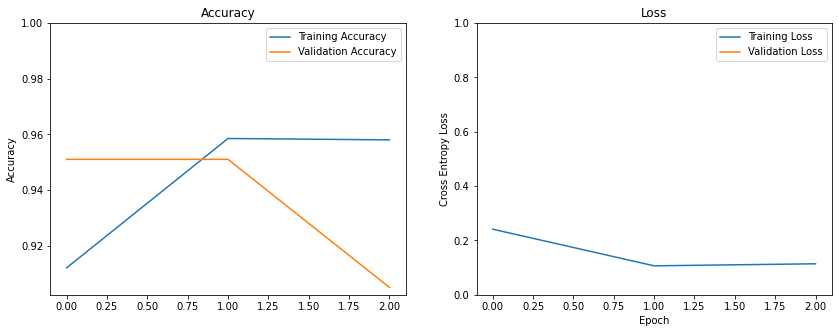

In [157]:
model_mn_ft = tf.keras.models.clone_model(model_mn)
model_mn_ft.set_weights(model_mn.get_weights())

# compiling
model_mn_ft.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# training
hist3 = model_mn_ft.fit(train_data_gen, 
                     epochs=len(hist2.history["loss"]) + 10,
                     initial_epoch=hist2.epoch[-1],
                     validation_data=val_data_gen, 
                     callbacks=[ClearCallback(), 
                                EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)])

# visualizing performance
print_performance(hist3.history)
print()
plot_history(hist3.history)

## **6) Comparing the results**

In [158]:
#@title
from IPython.display import Markdown as md
results_tab =  """<table width=70% align="left">
    <tr>
        <td><b><center><p>Model</p></center></b></td>
        <td><b><center><p>Loss</p></center></b></td>
        <td><b><center><p>Accuracy</p></center></b></td>
        <td><b><center><p>Training epochs</p></center></b></td>
    </tr>
    """

for name, hist in {"Built from scratch": hist1.history, "MobileNetV2 with frozen weights": hist2.history, "MobileNetV2 fine-tuning": hist3.history}.items():
     results_tab += f"""<tr>
            <td><center><p>{name}</p></center></td>
            <td><center><p>{hist["val_loss"][-1]:.4f}</p></center></td>
            <td><center><p>{100*hist["val_accuracy"][-1]:.2f}%</p></center></td>
            <td><center><p>{len(hist["loss"])}</p></center></td>
        </tr>"""

print("Performance on the validation set:\n")
md(results_tab)

Performance on the validation set:



<table width=70% align="left">
    <tr>
        <td><b><center><p>Model</p></center></b></td>
        <td><b><center><p>Loss</p></center></b></td>
        <td><b><center><p>Accuracy</p></center></b></td>
        <td><b><center><p>Training epochs</p></center></b></td>
    </tr>
    <tr>
            <td><center><p>Built from scratch</p></center></td>
            <td><center><p>0.4638</p></center></td>
            <td><center><p>77.90%</p></center></td>
            <td><center><p>30</p></center></td>
        </tr><tr>
            <td><center><p>MobileNetV2 with frozen weights</p></center></td>
            <td><center><p>0.0936</p></center></td>
            <td><center><p>96.10%</p></center></td>
            <td><center><p>15</p></center></td>
        </tr><tr>
            <td><center><p>MobileNetV2 fine-tuning</p></center></td>
            <td><center><p>1.5152</p></center></td>
            <td><center><p>90.50%</p></center></td>
            <td><center><p>3</p></center></td>
        </tr>

<table>

</table>